In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
#from keras.applications import VGG16
#tf.keras.applications.VGG16

2021-12-06 02:59:29.938533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 02:59:29.938578: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_dir = "/media/asmany/Drive_D/liveness/dataset/train"
valid_dir = "/media/asmany/Drive_D/liveness/dataset/test"
img_width, img_height = 224, 224 # Default input size for VGG16


In [3]:
# Instantiate convolutional base

conv_base = tf.keras.applications.VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

2021-12-06 02:59:38.930359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-06 02:59:38.930391: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-06 02:59:38.930409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (asmany-VivoBook-ASUSLaptop-X570DD): /proc/driver/nvidia/version does not exist
2021-12-06 02:59:38.930670: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,2))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 8895)  
validation_features, validation_labels = extract_features(valid_dir, 3719)
# test_features, test_labels = extract_features(test_dir, test_size)

Found 8895 images belonging to 2 classes.
Found 3719 images belonging to 2 classes.


In [5]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(2, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Compile model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

2021-12-06 04:03:32.010294: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 892631040 exceeds 10% of free system memory.


Epoch 1/150
266/278 [===========================>..] - ETA: 0s - loss: 0.3281 - acc: 0.9180
Epoch 00001: val_loss improved from inf to 0.19339, saving model to model-001-0.920517-0.986018.h5
278/278 [==============================] - 2s 5ms/step - loss: 0.3215 - acc: 0.9205 - val_loss: 0.1934 - val_acc: 0.9860
Epoch 2/150
262/278 [===========================>..] - ETA: 0s - loss: 0.1223 - acc: 0.9849
Epoch 00002: val_loss improved from 0.19339 to 0.11343, saving model to model-002-0.984486-0.990589.h5
278/278 [==============================] - 1s 3ms/step - loss: 0.1210 - acc: 0.9845 - val_loss: 0.1134 - val_acc: 0.9906
Epoch 3/150
267/278 [===========================>..] - ETA: 0s - loss: 0.0762 - acc: 0.9892
Epoch 00003: val_loss improved from 0.11343 to 0.08602, saving model to model-003-0.989320-0.992740.h5
278/278 [==============================] - 1s 3ms/step - loss: 0.0760 - acc: 0.9893 - val_loss: 0.0860 - val_acc: 0.9927
Epoch 4/150
263/278 [===========================>..] - E

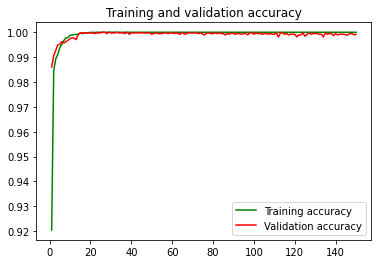

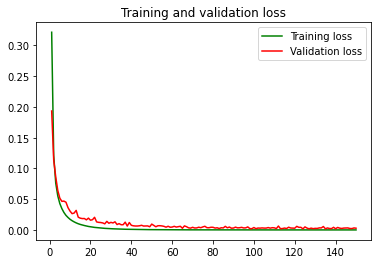

In [7]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from keras.preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))
        
    classes = ["FAKE.......", "REAL.........."]
    print(str(classes[np.argmax(np.array(prediction[0]))]))

In [ ]:
/media/asmany/Drive_D/liveness/.idea/notebook.ipynb

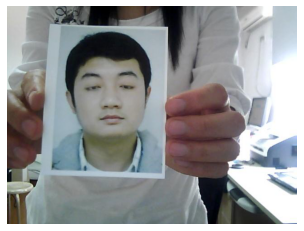

FAKE.......


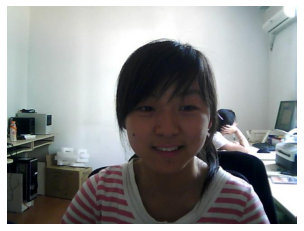

REAL..........


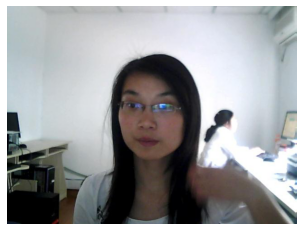

REAL..........


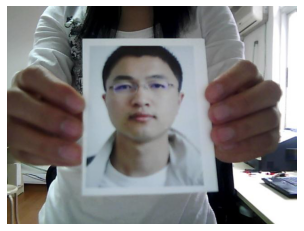

FAKE.......


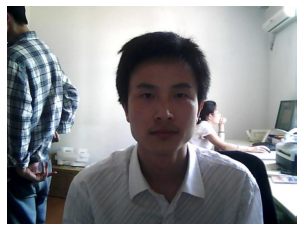

REAL..........


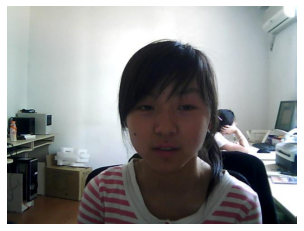

REAL..........


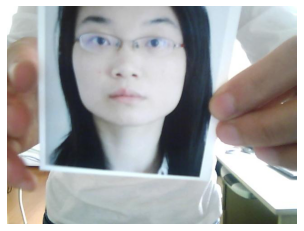

FAKE.......


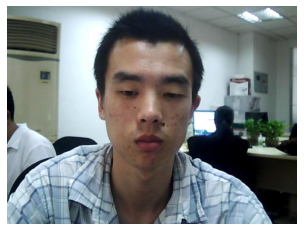

REAL..........


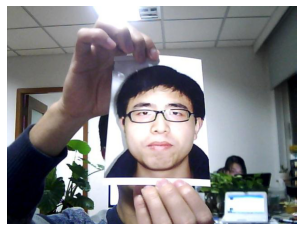

FAKE.......


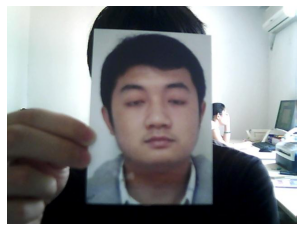

FAKE.......


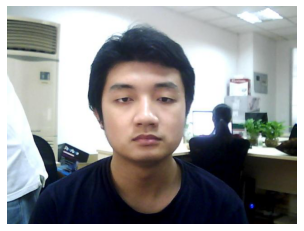

REAL..........


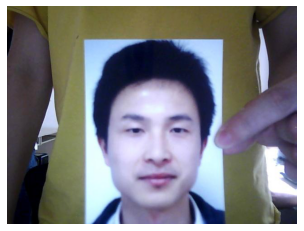

FAKE.......


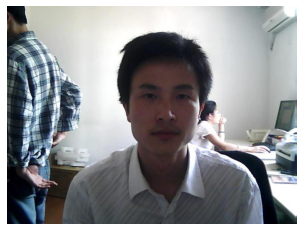

REAL..........


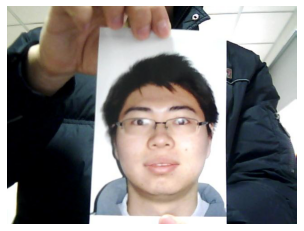

FAKE.......


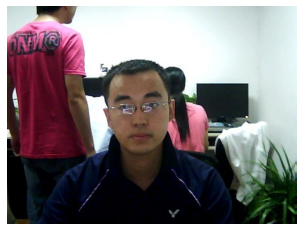

REAL..........


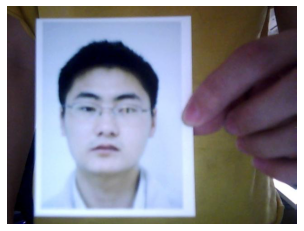

FAKE.......


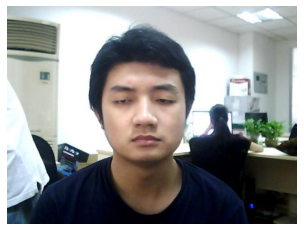

REAL..........


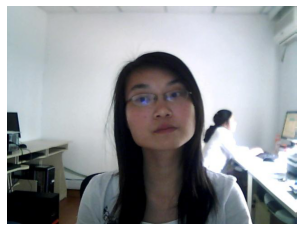

REAL..........


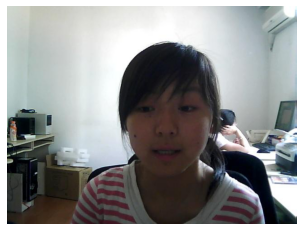

REAL..........


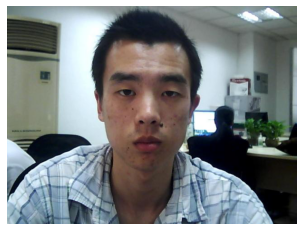

REAL..........


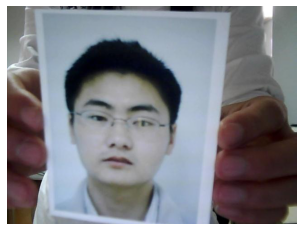

FAKE.......


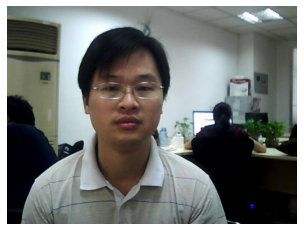

REAL..........


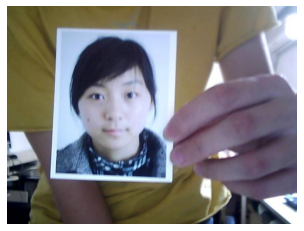

FAKE.......


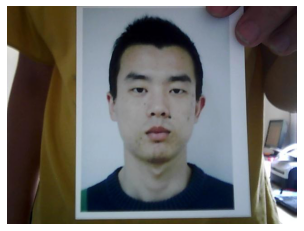

FAKE.......


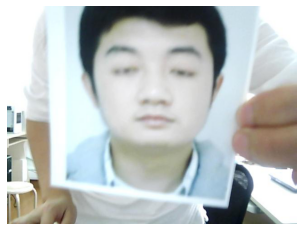

FAKE.......


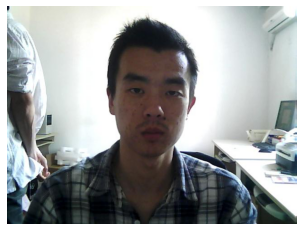

REAL..........


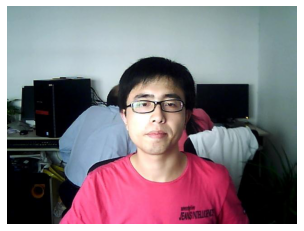

REAL..........


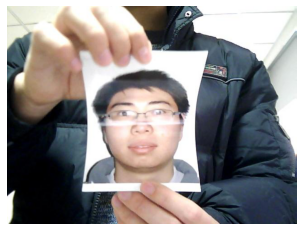

FAKE.......


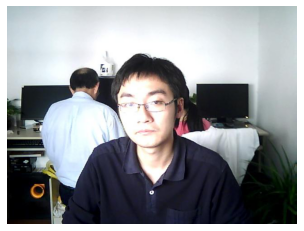

REAL..........


In [20]:
pred_dir = "/media/asmany/Drive_D/liveness/test/"
import random
pred_files = random.sample(os.listdir(pred_dir),29)
for f in pred_files:
    prediction(pred_dir+f)